In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/koi_cumulative.csv', comment='#')
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['koi_disposition'].value_counts()}")

Dataset shape: (9564, 49)
Class distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64


## Program 8: Gradient Boosting (XGBoost) — Exoplanet Classification

**Scientific Background:**  
Gradient Boosting builds an ensemble of **weak learners** (shallow decision trees)
sequentially, where each new tree corrects the errors of the previous ones.

Unlike Random Forests (parallel trees), Gradient Boosting is **sequential** —
each tree learns from the residual errors of the combined ensemble so far.
XGBoost (Extreme Gradient Boosting) adds regularization to prevent overfitting.

**Why this is expected to be our best model:**
- Handles feature correlations naturally (unlike Naive Bayes)
- More flexible than a single Decision Tree
- Built-in regularization (unlike vanilla Decision Trees)
- Handles class imbalance via `scale_pos_weight`

In [2]:
data = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()
data['label'] = (data['koi_disposition'] == 'CONFIRMED').astype(int)

features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth',
            'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad',
            'koi_prad', 'koi_teq']

data = data[features + ['label']].dropna()
print(f"Usable rows: {len(data)}")

X = data[features].values
y = data['label'].values

# Class imbalance ratio for XGBoost
neg, pos = sum(y==0), sum(y==1)
scale_pos_weight = neg / pos
print(f"CONFIRMED: {pos} | FALSE POSITIVE: {neg}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Usable rows: 7326
CONFIRMED: 2744 | FALSE POSITIVE: 4582
scale_pos_weight: 1.67


In [3]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)

print("Training XGBoost... ")
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("=" * 50)
print("      GRADIENT BOOSTING (XGBoost) RESULTS")
print("=" * 50)
print(f"  Estimators  : 300 trees")
print(f"  Max Depth   : 5")
print(f"  Learning Rate: 0.1")
print(f"  Accuracy    : {acc:.4f} ({acc*100:.2f}%)")
print(f"  ROC-AUC     : {auc:.4f}")
print("=" * 50)
print(classification_report(y_test, y_pred,
      target_names=['FALSE POSITIVE', 'CONFIRMED']))

Training XGBoost... 
      GRADIENT BOOSTING (XGBoost) RESULTS
  Estimators  : 300 trees
  Max Depth   : 5
  Learning Rate: 0.1
  Accuracy    : 0.9209 (92.09%)
  ROC-AUC     : 0.9763
                precision    recall  f1-score   support

FALSE POSITIVE       0.96      0.92      0.94       917
     CONFIRMED       0.87      0.93      0.90       549

      accuracy                           0.92      1466
     macro avg       0.91      0.92      0.92      1466
  weighted avg       0.92      0.92      0.92      1466



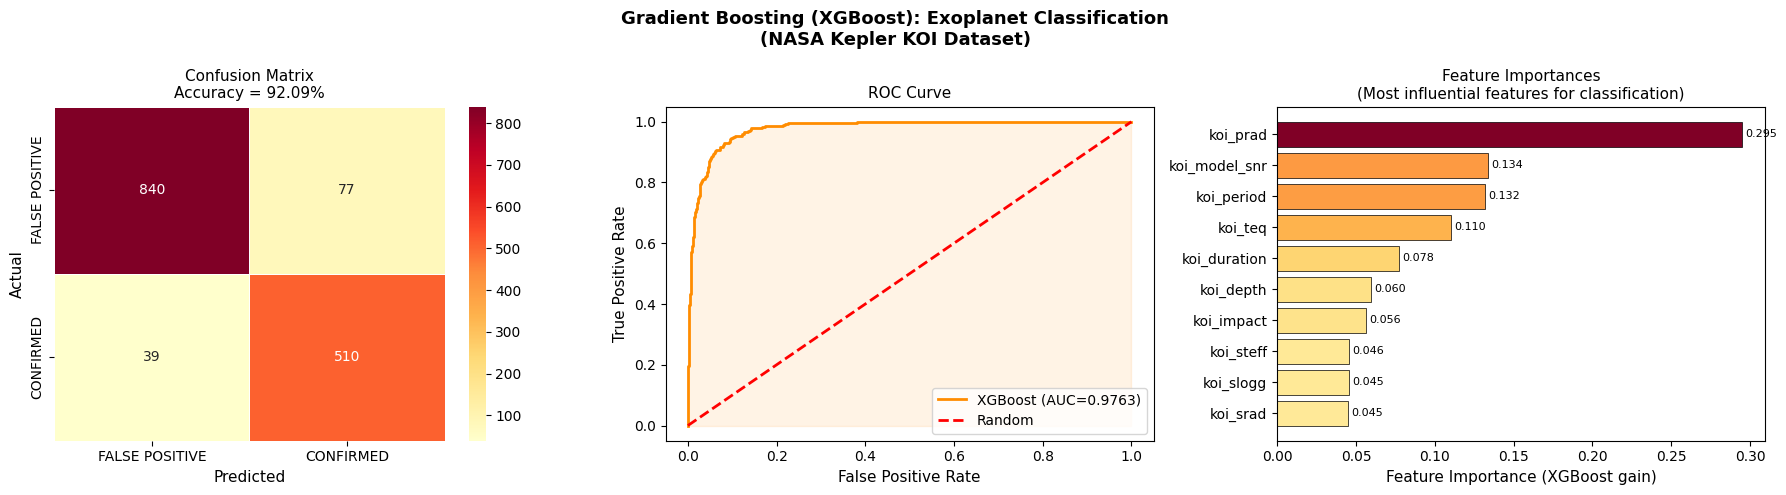

Plot saved!


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Gradient Boosting (XGBoost): Exoplanet Classification\n(NASA Kepler KOI Dataset)',
             fontsize=13, fontweight='bold')

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0],
            xticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            yticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            linewidths=0.5)
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_title(f'Confusion Matrix\nAccuracy = {acc*100:.2f}%', fontsize=11)

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'XGBoost (AUC={auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'r--', lw=2, label='Random')
axes[1].fill_between(fpr, tpr, alpha=0.1, color='darkorange')
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=11)
axes[1].legend(loc='lower right')

# Plot 3: Feature Importances
importances = model.feature_importances_
sorted_idx = np.argsort(importances)
colors = plt.cm.YlOrRd(importances[sorted_idx] / importances.max())
bars = axes[2].barh([features[i] for i in sorted_idx],
                     importances[sorted_idx],
                     color=colors, edgecolor='black', linewidth=0.5)
axes[2].set_xlabel('Feature Importance (XGBoost gain)', fontsize=11)
axes[2].set_title('Feature Importances\n(Most influential features for classification)', fontsize=11)
for bar, imp in zip(bars, importances[sorted_idx]):
    axes[2].text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
                f'{imp:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('../outputs/plots/08_gradient_boosting.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved!")

In [5]:
top3_idx = np.argsort(model.feature_importances_)[::-1][:3]

print("Gradient Boosting: Scientific Interpretation")
print("=" * 55)
print(f"""
XGBoost sequentially built 300 decision trees, each
correcting the errors of the previous ensemble.

Top 3 most important features:
  1. {features[top3_idx[0]]:15s} → {model.feature_importances_[top3_idx[0]]:.4f}
  2. {features[top3_idx[1]]:15s} → {model.feature_importances_[top3_idx[1]]:.4f}
  3. {features[top3_idx[2]]:15s} → {model.feature_importances_[top3_idx[2]]:.4f}

FINAL Performance Leaderboard:
  • Naive Bayes         : 71.01%  AUC: 0.8802
  • Logistic Regression : 74.01%  AUC: 0.8202
  • SVM (RBF)           : 84.45%  AUC: 0.9303
  • k-NN (k=13)         : 85.20%  AUC: 0.9228
  • Decision Tree       : 87.59%
  • XGBoost             : {acc*100:.2f}%  AUC: {auc:.4f} ← champion?

XGBoost handles correlated features, class imbalance,
and non-linear boundaries simultaneously — making it
the most powerful model in our pipeline.

These feature importances will form a key figure in
our research paper's results section.
""")

Gradient Boosting: Scientific Interpretation

XGBoost sequentially built 300 decision trees, each
correcting the errors of the previous ensemble.

Top 3 most important features:
  1. koi_prad        → 0.2947
  2. koi_model_snr   → 0.1339
  3. koi_period      → 0.1319

FINAL Performance Leaderboard:
  • Naive Bayes         : 71.01%  AUC: 0.8802
  • Logistic Regression : 74.01%  AUC: 0.8202
  • SVM (RBF)           : 84.45%  AUC: 0.9303
  • k-NN (k=13)         : 85.20%  AUC: 0.9228
  • Decision Tree       : 87.59%
  • XGBoost             : 92.09%  AUC: 0.9763 ← champion?

XGBoost handles correlated features, class imbalance,
and non-linear boundaries simultaneously — making it
the most powerful model in our pipeline.

These feature importances will form a key figure in
our research paper's results section.

